# Plot terminus picks over images and terminus position time series

#### Jukes Liu

## 1) Set-up

In [125]:
# import sys
# # !{sys.executable} -m pip install fiona
# !{sys.executable} -m pip install opencv-python

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import pandas as pd    
from time import sleep
from IPython.display import clear_output
import scipy.stats
import datetime
import math
import shutil
import subprocess

csvpaths = '/home/jukes/Documents/Sample_glaciers/'
basepath = '/media/jukes/jukes1/LS8aws/'
massorsize = "mass"

### Read in data from csv files

1) Read in __image dates__ from imgdates.csv

In [316]:
#Read in datetags csv as datetime_df
datetime_df = pd.read_csv(csvpaths+'imgdates_SE_focus.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
print(datetime_df.shape)
datetime_df.head()

(629, 2)


,Scene,datetimes
1074,LC08_L1TP_231014_20130320_20170505_01_T1,2013-03-20
18,LC08_L1TP_232016_20130402_20170505_01_T1,2013-04-02
1296,LC08_L1TP_231013_20130414_20170505_01_T1,2013-04-14
1070,LC08_L1TP_231014_20130414_20170505_01_T1,2013-04-14
1083,LC08_L1TP_231014_20130430_20170505_01_T1,2013-04-30


2) Read in csv with the __metric and order__ for each terminus pick from terminuspicks_massorsize_date.csv

In [23]:
# analysis_date = '2020_05_07'
# for file in os.listdir(csvpaths):
#     if analysis_date in file and file.endswith('.csv'):
#         thefile = file
# order_df = pd.read_csv(csvpaths+thefile, sep=',', dtype=str, header=1, usecols=[0,1,2,3,4])
# order_df = order_df.dropna()
# print(order_df.shape)
# order_df.head(10)

3) Read in __centerline information__ for each terminus box rom Boxes_coords_pathrows.csv

In [317]:
centerline_df = pd.read_csv(csvpaths+'Boxes_coords_pathrows_SE_focus.csv', sep=',', dtype=str, header=0)
centerline_df = centerline_df.set_index('BoxID')
print(centerline_df.shape)
centerline_df

(7, 15)


,lmid50_x,lmid50_y,rmid50_x,m50,b50,lmid25_x,lmid25_y,rmid25_x,m25,b25,lmid75_x,lmid75_y,rmid75_x,m75,b75
BoxID,,,,,,,,,,,,,,,
245,128.5,147.5,219.5,0.7527472527472527,50.77197802197803,140.25,131.75,231.25,0.7554945054945055,26.17719780219781,116.75,163.25,207.75,0.75,75.36675824175825
296,89.0,114.5,175.5,0.04046242774566474,110.89884393063583,89.5,102.75,175.75,0.03768115942028986,99.128612716763,88.5,126.25,175.25,0.043227665706051875,122.66907514450867
220,149.5,228.5,244.5,-0.8315789473684211,352.82105263157894,133.75,209.75,229.25,-0.8219895287958116,320.9736842105263,165.25,247.25,259.75,-0.8412698412698413,384.6684210526316
240,217.5,288.5,342.0,-0.42168674698795183,380.2168674698795,199.75,247.25,324.0,-0.4245472837022133,331.48192771084337,235.25,329.75,360.0,-0.4188376753507014,428.95180722891564
277,100.5,148.5,193.0,0.16216216216216217,132.2027027027027,103.25,134.75,195.0,0.16893732970027248,118.00675675675676,97.75,162.25,191.0,0.1554959785522788,146.39864864864865
270,110.5,163.5,206.0,-0.1518324607329843,180.27748691099475,107.25,142.75,202.5,-0.16010498687664043,159.03403141361255,113.75,184.25,209.5,-0.14360313315926893,201.52094240837695
246,103.5,162.0,185.5,-0.4878048780487805,212.4878048780488,94.75,143.5,176.25,-0.49079754601226994,189.71951219512195,112.25,180.5,194.75,-0.48484848484848486,235.2560975609756


4) Read in __glacier velocities__ from Glacier_velocities.csv

In [318]:
#Read in glacier velocity data
flowspeed_df= pd.read_csv(csvpaths+'Glacier_vel_measures_SE_focus.csv', sep=',', dtype=str)
flowspeed_df = flowspeed_df.set_index('BoxID')

### Import functions:

There are 5 functions that are used throughout the script. __calc_changerates()__ takes a dataframe containing terminus positions and dates of analysis and calculates the terminus change rates. __remove_dips()__ takes a dataframe and a flow speed threshold and removes all points that show an unrealistically large negative change rate followed by an unrealistically large positive change rate. __remove_jumps()__ takes the same inputs and removes all values that show an unrealistically large positive change rate (a jump). __within()__ takes a test value and determines whether it is within a given interval around the set value. This is used for determining whether the points of the centerline "intersect" with the terminus pick points. __distance()__ calculates distance between 2 points using the distance formula. This will be used to calculate terminus position (distance between interesction point and reference point).

In [319]:
os.chdir('/home/jukes/automated-glacier-terminus')

from automated_terminus_functions import calc_changerates1, remove_dips, remove_jumps, within, distance, to_datetimes

## 2) Plot analyzed images and terminus picks for one glacier sequentially

If images have not been converted to png from pgm, run the following cell but change the BoxID to the right ID:

In [138]:
# BoxIDs= set(list(order_df['BoxID']))
# for BoxID in BoxIDs:
#     command = 'cd '+basepath+'Box'+str(BoxID)+'/rotated/; '+'mogrify -format png *.TIF'
#     print(command)
#     subprocess.call(command, shell=True)

#### Load in the images, scene names, and dat file names for all the resulting terminus picks

In [321]:
BOI= '246'; print("Box"+BOI)

metric = "Datfiles_c1/"; imagepath = basepath+"Box"+BOI+"/rotated_c1/"

#grab the order_df subset for just the box:
order_box_df = pd.read_csv(csvpaths+'Tpos_Box'+BOI+'_flowline50_filtered.csv',  dtype=str, usecols=[1,2,3,4,5,6,7,8,9])

Box246


In [ ]:
#make results directory in BoxID folder if it doesn't already exist
if os.path.exists(basepath+"Box"+BOI+"/Results_c1/"):
    shutil.rmtree(basepath+"Box"+BOI+"/Results_c1/"); print("Results folder wiped and new created")
    os.mkdir(basepath+"Box"+BOI+"/Results_c1/")
#OTHERWISE, create the folder and download into it
else:
    os.mkdir(basepath+"Box"+BOI+"/Results_c1/"); print("Results folder made")

In [322]:
order_box_df = order_box_df.drop('BoxID', axis=1)
order_box_df = order_box_df.dropna()
print(order_box_df.shape)
order_box_df.head()

(101, 8)


,Scene,Scale,datetimes,Metric,Order,tpos,X,changerate
1,LC08_L1TP_233015_20130903_20170502_01_T1,000,2013-09-03,489743.2539062500,1,757.5,"[154.0, 138.0]",-0.9375
2,LC08_L1TP_232015_20130928_20180528_01_T1,001,2013-09-28,285664.5500488281,1,742.5,"[153.0, 138.0]",-0.6
3,LC08_L1TP_233015_20131005_20170429_01_T1,000,2013-10-05,481176.2351074219,1,742.5,"[153.0, 138.0]",0.0
4,LC08_L1TP_233015_20131021_20170429_01_T1,000,2013-10-21,193597.7490234375,1,697.5,"[150.0, 140.0]",-2.8125
5,LC08_L1TP_233015_20131122_20170428_01_T1,000,2013-11-22,48326.8571166992,1,742.5,"[153.0, 138.0]",1.640625


In [323]:
#make lists to store image data and grab image files
image_arrays = []; dats = []; trimdats = []; imgnames = []; boxids = []; scales = []

#image path
imgfiles = os.listdir(imagepath)

for imgfile in imgfiles:
    #grab image files and append to images list
    if imgfile.endswith(BOI+"_PS.png"):
#         print(imgfile)
        image = mpimg.imread(imagepath+imgfile); imgname = imgfile[0:-4]; scenename = imgname[2:42]
        
        pathtodat = imagepath+imgname+".pgm_max_gaussian/"+metric
        datfiles = os.listdir(pathtodat)
        
        #if there are datfiles, grab the trimmed and non-trimmed files
        if len(datfiles) > 1: 
            #find the trimmed dat file and the original
            for dat in datfiles:
                if "trim" in dat:
                    datfile_trim = dat
                    #append to trimmed dats list
                    trimdats.append(datfile_trim)
                    #grab the scale and append the equivalent original dat
                    scale = dat[-7:-4]
                    datfile = "terminus_"+scale+".dat"
                    dats.append(datfile)
                    
                    #append the image array and the image name to the list
                    image_arrays.append(image); imgnames.append(scenename); boxids.append(BOI); scales.append(scale)

print(len(image_arrays), len(dats), len(trimdats), len(imgnames),len(boxids), len(scales))
images_df = pd.DataFrame(list(zip(imgnames, boxids, image_arrays, dats, trimdats, scales)),
              columns=['Scene','BoxID','Image_array', 'Dat_filename', "Trimmed_dat_filename", "Scale"])
print(images_df.shape)

680 680 680 680 680 680
(680, 6)


#### Join dates to images_df by joining on Scene:

In [324]:
images_df.sort_values(by='Scene')
datetime_df = datetime_df.sort_values(by='Scene')
print(datetime_df.shape)
new_df = images_df.merge(datetime_df, how= 'inner', on = 'Scene')
dated_images_df = new_df.sort_values(by='datetimes', ascending = True)
print(dated_images_df.shape)
dated_images_df.head()

(629, 2)
(680, 7)


,Scene,BoxID,Image_array,Dat_filename,Trimmed_dat_filename,Scale,datetimes
445,LC08_L1TP_233015_20130818_20180426_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_002.dat,terminus_trim_002.dat,002,2013-08-18
446,LC08_L1TP_233015_20130818_20180426_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_001.dat,terminus_trim_001.dat,001,2013-08-18
447,LC08_L1TP_233015_20130818_20180426_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_003.dat,terminus_trim_003.dat,003,2013-08-18
448,LC08_L1TP_233015_20130818_20180426_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2013-08-18
449,LC08_L1TP_233015_20130818_20180426_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_004.dat,terminus_trim_004.dat,004,2013-08-18


#### Join "order" to dated_images_df by joining on scale and scene and sort the dataframe

In [325]:
final_images_df = dated_images_df.merge(order_box_df, how='inner', on=['Scene', 'Scale', 'datetimes'])
#sort the DataFrame by date of delineation from earliest to latest AND order
final_images_df = final_images_df.sort_values(by=['datetimes','Scene','Order'], ascending=True)
final_images_df.head()

,Scene,BoxID,Image_array,Dat_filename,Trimmed_dat_filename,Scale,datetimes,Metric,Order,tpos,X,changerate
0,LC08_L1TP_233015_20130903_20170502_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2013-09-03,489743.2539062500,1,757.5,"[154.0, 138.0]",-0.9375
1,LC08_L1TP_232015_20130928_20180528_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_001.dat,terminus_trim_001.dat,001,2013-09-28,285664.5500488281,1,742.5,"[153.0, 138.0]",-0.6
2,LC08_L1TP_233015_20131005_20170429_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2013-10-05,481176.2351074219,1,742.5,"[153.0, 138.0]",0.0
3,LC08_L1TP_233015_20131021_20170429_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2013-10-21,193597.7490234375,1,697.5,"[150.0, 140.0]",-2.8125
4,LC08_L1TP_233015_20131122_20170428_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2013-11-22,48326.8571166992,1,742.5,"[153.0, 138.0]",1.640625


In [14]:
# #separate the df out into data for the different centrlines
# final_images_25 = final_images_df.copy()
# final_images_75 = final_images_df.copy()

In [15]:
# final_images_df.head()

## Calculate terminus positions:

### Terminus position:

In [326]:
#LOAD IN REFERENCE POINTS to calculate terminus position with respect to
box_midpoint_x = np.float(centerline_df.loc[BOI, 'lmid50_x']); box_midpoint_y = np.float(centerline_df.loc[BOI, 'lmid50_y'])
boxmid_x_25 = np.float(centerline_df.loc[BOI, 'lmid25_x']); boxmid_y_25 = np.float(centerline_df.loc[BOI, 'lmid25_y'])
boxmid_x_75 = np.float(centerline_df.loc[BOI, 'lmid75_x']); boxmid_y_75 = np.float(centerline_df.loc[BOI, 'lmid75_y'])

#GRAB CENTERLINE POINTS
#grab slopes and intercepts from the dataframe
c_slope = float(centerline_df.loc[BOI]['m50']); c_intercept = float(centerline_df.loc[BOI]['b50']) 
c25_slope = float(centerline_df.loc[BOI]['m25']); c25_intercept = float(centerline_df.loc[BOI]['b25'])
c75_slope = float(centerline_df.loc[BOI]['m75']); c75_intercept = float(centerline_df.loc[BOI]['b75'])  

#grab range of x-values
xmin50 = float(box_midpoint_x); xmax50 = float(centerline_df.loc[BOI, 'rmid50_x']); ymid50 = float(box_midpoint_y)
xmin25 = float(boxmid_x_25); xmax25 = float(centerline_df.loc[BOI, 'rmid25_x']); ymid25 = float(boxmid_y_25)
xmin75 = float(boxmid_x_75); xmax75 = float(centerline_df.loc[BOI, 'lmid75_x']); ymid75 = float(boxmid_y_75)
xmax = np.max([xmax50, xmax25, xmax75]); xmin = np.min([xmin50, xmin25, xmin75]); c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)

#calculate y-values using the various centerlines
c_y = c_slope*c_x + c_intercept; c_y_25 = c25_slope*c_x + c25_intercept; c_y_75 = c75_slope*c_x + c75_intercept

#LISTS TO HOLD TERMINUS POSITIONS AND INTERSECTION POINTS
terminus_positions = []; tpositions_25 = []; tpositions_75 = []
intersections = []; X25 = []; X75 = []

#for each scene and scale:
for index, row in final_images_df.iterrows():
    trimdat = row['Trimmed_dat_filename']; dat = row['Dat_filename']; scene = row['Scene']    
    #CALCULATE TERMINUS POSITION
    #load in dat files and calculate intersection points
    datpath = imagepath+"R_"+scene+"_B8_Buffer"+BOI+"_PS.pgm_max_gaussian/"+metric
#     term_trimdat = np.loadtxt(datpath+trimdat)
    term_dat = np.loadtxt(datpath+dat)                          
    intersect_xs = []; intersect_xs_25 = []; intersect_xs_75 = []
    intersect_ys = []; intersect_ys_25 = []; intersect_ys_75 = []
    
    #loop through all the x,y values for the centerline
    for j in range(0, len(c_x)):
        x = c_x[j]; y = c_y[j]; y25 = c_y_25[j]; y75 = c_y_75[j]        
        interval = 0.6
        #where are the intersections with the terminus pick?
#         for dat_x, dat_y in term_trimdat:
        for dat_x, dat_y in term_dat:
            #midway centerline
            if within(dat_x, x, interval) and within (dat_y, y, interval):
                #intersect_x = dat_x; intersect_y = dat_y; intersect_found = True
                intersect_xs.append(dat_x); intersect_ys.append(dat_y)            
            #1/4th centerline
            if within(dat_x, x, interval) and within (dat_y, y25, interval):
                intersect_xs_25.append(dat_x); intersect_ys_25.append(dat_y)              
            #3/4th centerline
            if within(dat_x, x, interval) and within (dat_y, y75, interval):
                intersect_xs_75.append(dat_x); intersect_ys_75.append(dat_y)
    #for 50 centerline
    #if no intersections are found with the terminus line, append Nans
    if len(intersect_xs) == 0:
        tpos50 = np.NaN; intersect_x = np.NaN; intersect_y = np.NaN
    #if at least one is found:
    else:
        #intersection with the greatest x
        #use distance formula to calculate distance between
        max_index = intersect_xs.index(np.max(intersect_xs))
        intersect_x = intersect_xs[max_index]; intersect_y = intersect_ys[max_index]
#         term_position = distance(xmin50, ymid50, intersect_x, intersect_y)*15.0
        tpos50 = (intersect_x-xmin50)*15.0
#         print(tpos50)

    #for 25 centerline
    if len(intersect_xs_25) == 0:
        tpos25 = np.NaN; intersect_x25 = np.NaN; intersect_y25 = np.NaN
    else:
        max_index_25 = intersect_xs_25.index(np.max(intersect_xs_25))
        intersect_x25 = intersect_xs_25[max_index_25]; intersect_y25 = intersect_ys_25[max_index_25]
        tpos25 = (intersect_x25-xmin25)*15.0
#         tpos25 = distance(xmin25, ymid25, intersect_x25, intersect_y25)*15.0
    
    #for 75 centerline
    if len(intersect_xs_75) == 0:
        tpos75 = np.NaN; intersect_x75 = np.NaN; intersect_y75 = np.NaN
    else:
        max_index_75 = intersect_xs_75.index(np.max(intersect_xs_75))
        intersect_x75 = intersect_xs_75[max_index_75]; intersect_y75 = intersect_ys_75[max_index_75]
        tpos75 = (intersect_x75-xmin75)*15.0
#         tpos75 = distance(xmin75, ymid75, intersect_x75, intersect_y75)*15.0
        
    #append to lists
    terminus_positions.append(tpos50); tpositions_25.append(tpos25); tpositions_75.append(tpos75)
    intersections.append([intersect_x, intersect_y]); X25.append([intersect_x25, intersect_y25]); X75.append([intersect_x75, intersect_y75])
    
# ADD TERMINUS POSITION AND INTERSECTIONS
final_images_df['tpos50'] = terminus_positions; final_images_df['tpos25'] = tpositions_25; final_images_df['tpos75'] = tpositions_75
final_images_df['X50'] = intersections ;final_images_df['X25'] = X25; final_images_df['X75'] = X75
print(final_images_df.shape)

(101, 18)


### Calculate terminus change rates (m/d):

In [15]:
# #Split into 3 dataframes
# final_images_50 = final_images_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
#                                   'tpos50', 'X50',]].copy().reset_index(drop=True)
# final_images_50 = final_images_50.rename(columns={"tpos50": "tpos", "X50": "X"})
# final_images_25 = final_images_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
#                                   'tpos25', 'X25']].copy().reset_index(drop=True)
# final_images_25 = final_images_25.rename(columns={"tpos25": "tpos", "X25": "X"})
# final_images_75 = final_images_df[['Scene', 'BoxID', 'Scale', 'datetimes', 'Metric', 'Order', 
#                                   'tpos75', 'X75']].copy().reset_index(drop=True)
# final_images_75 = final_images_75.rename(columns={"tpos75": "tpos", "X75": "X"})

# dfs = [final_images_50, final_images_25, final_images_75]

In [16]:
# dfs_new = []
# for df in dfs: 
#     to_datetimes(df)
#     dfs_new.append(calc_changerates1(df))

In [19]:
# final_images_df.head()

## 3) Show each image & all (up to 5) terminus picks at a time:

In [327]:
to_datetimes(final_images_df)

,Scene,BoxID,Image_array,Dat_filename,Trimmed_dat_filename,Scale,datetimes,Metric,Order,tpos,X,changerate,tpos50,tpos25,tpos75,X50,X25,X75
0,LC08_L1TP_233015_20130903_20170502_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2013-09-03,489743.2539062500,1,757.5,"[154.0, 138.0]",-0.9375,757.5,753.75,611.25,"[154.0, 138.0]","[145.0, 119.0]","[153.0, 161.0]"
1,LC08_L1TP_232015_20130928_20180528_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_001.dat,terminus_trim_001.dat,001,2013-09-28,285664.5500488281,1,742.5,"[153.0, 138.0]",-0.6,742.5,723.75,611.25,"[153.0, 138.0]","[143.0, 120.0]","[153.0, 161.0]"
2,LC08_L1TP_233015_20131005_20170429_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2013-10-05,481176.2351074219,1,742.5,"[153.0, 138.0]",0.0,742.5,723.75,506.25,"[153.0, 138.0]","[143.0, 119.0]","[146.0, 165.0]"
3,LC08_L1TP_233015_20131021_20170429_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2013-10-21,193597.7490234375,1,697.5,"[150.0, 140.0]",-2.8125,697.5,NaN,NaN,"[150.0, 140.0]","[nan, nan]","[nan, nan]"
4,LC08_L1TP_233015_20131122_20170428_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2013-11-22,48326.8571166992,1,742.5,"[153.0, 138.0]",1.640625,742.5,NaN,626.25,"[153.0, 138.0]","[nan, nan]","[154.0, 161.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,LC08_L1TP_232015_20200323_20200326_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2020-03-23,531631.5375976562,1,622.5,"[145.0, 142.0]",0.9375,622.5,558.75,NaN,"[145.0, 142.0]","[132.0, 125.0]","[nan, nan]"
97,LC08_L1TP_232015_20200424_20200424_01_RT,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2020-04-24,293896.6728515625,1,637.5,"[146.0, 141.0]",0.46875,637.5,NaN,596.25,"[146.0, 141.0]","[nan, nan]","[152.0, 162.0]"
98,LC08_L1TP_233015_20200501_20200501_01_RT,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2020-05-01,684330.9960937500,1,652.5,"[147.0, 141.0]",2.142857142857143,652.5,573.75,581.25,"[147.0, 141.0]","[133.0, 125.0]","[151.0, 162.0]"
99,LC08_L1TP_233015_20200501_20200509_01_T1,246,"[[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], ...",terminus_000.dat,terminus_trim_000.dat,000,2020-05-01,684306.7382812500,1,652.5,"[147.0, 141.0]",2.142857142857143,652.5,573.75,581.25,"[147.0, 141.0]","[133.0, 125.0]","[151.0, 162.0]"


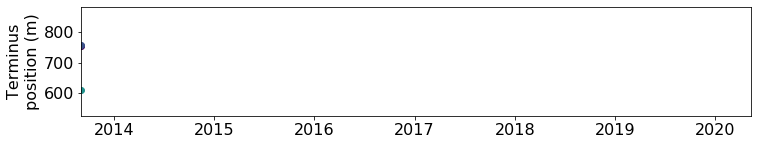

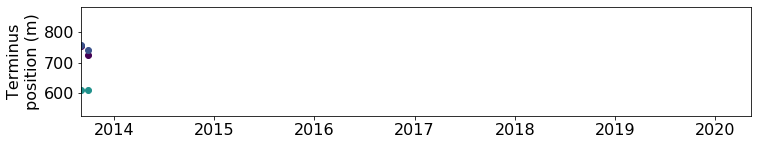

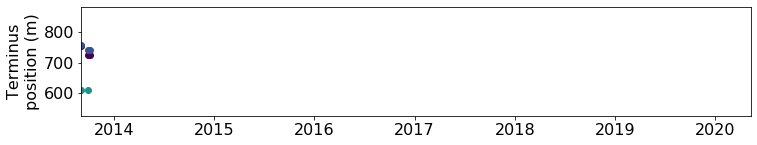

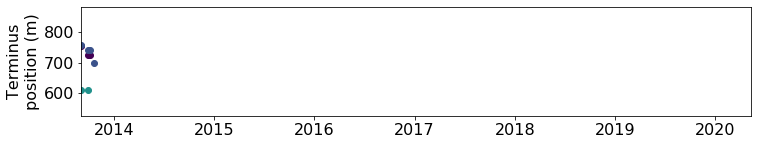

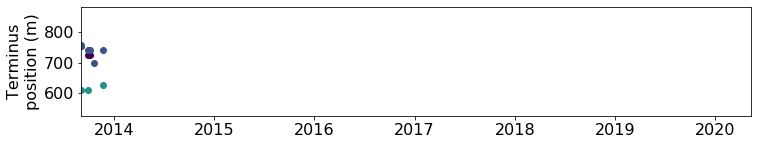

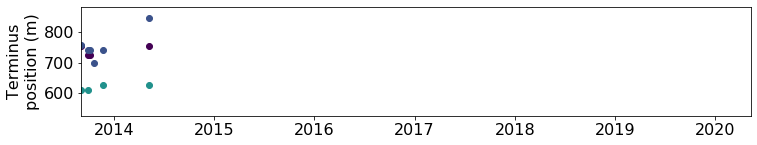

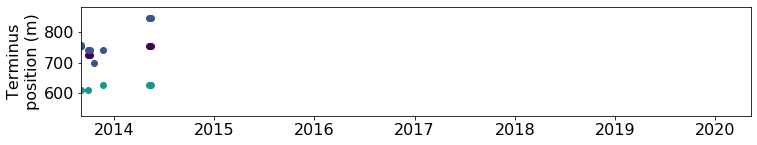

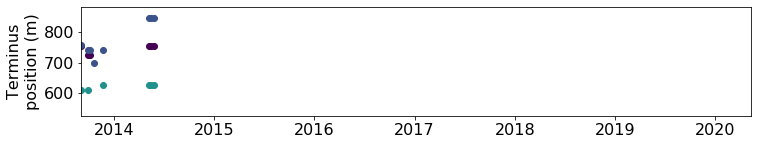

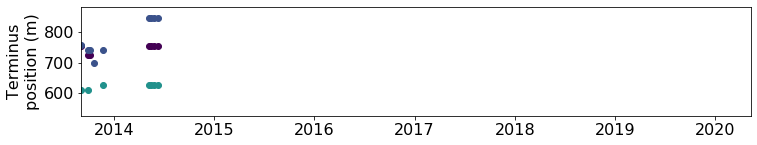

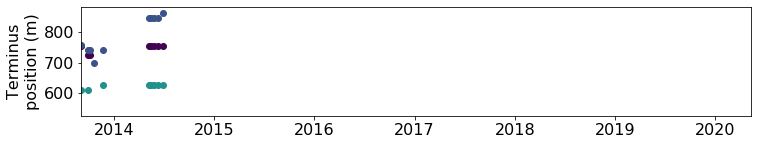

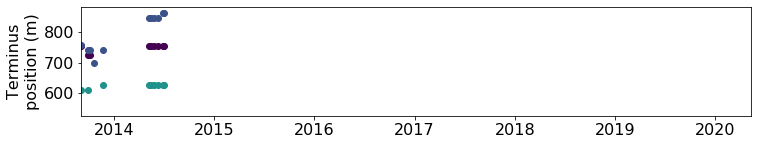

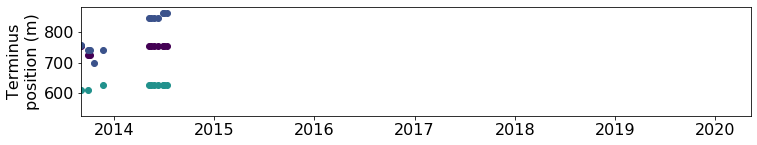

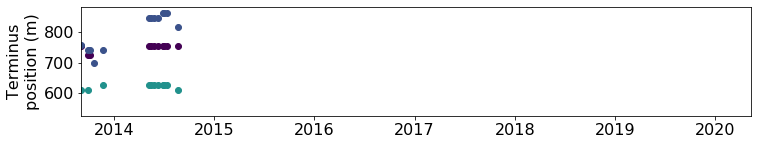

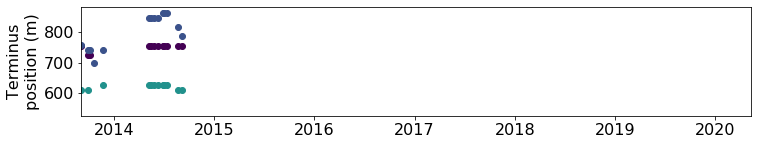

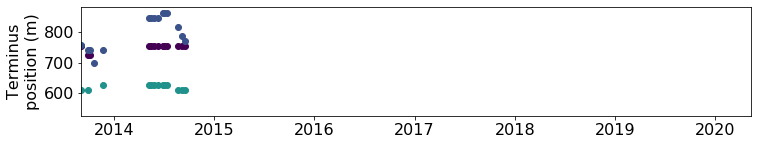

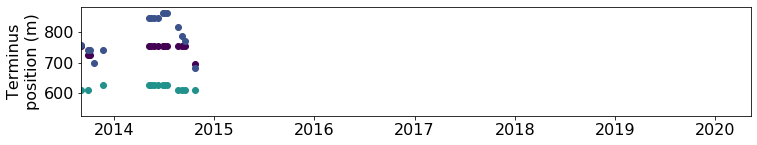

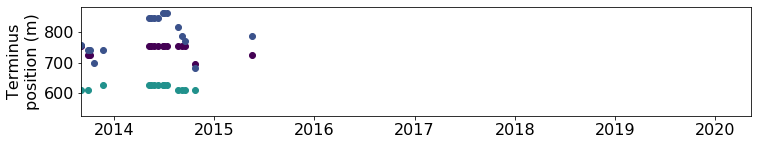

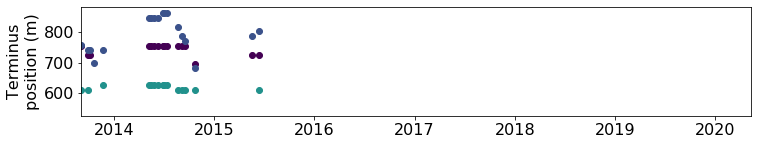

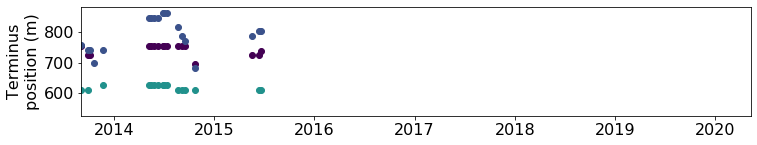

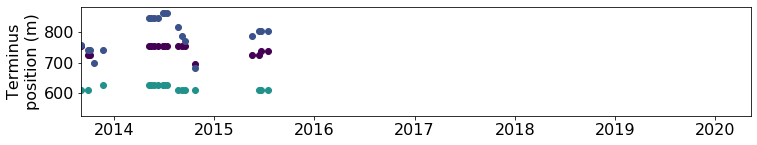

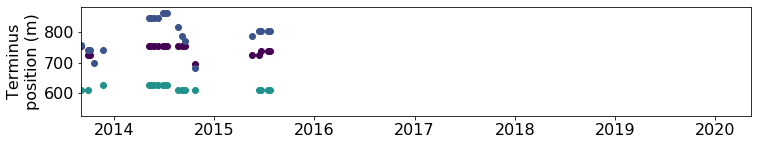

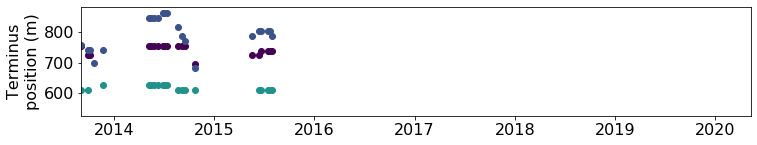

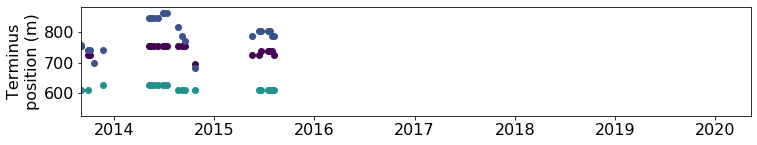

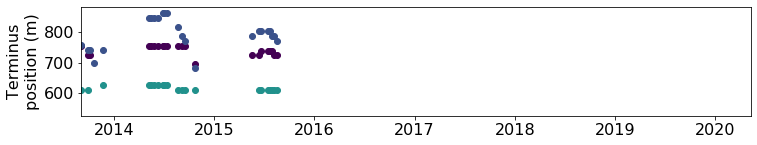

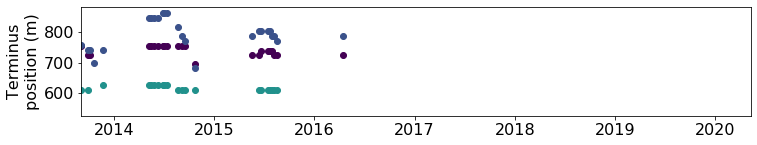

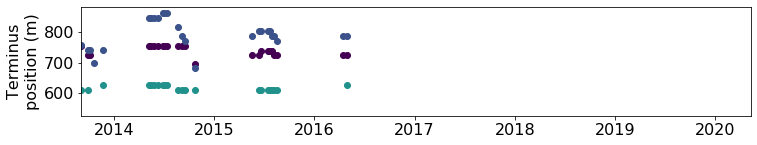

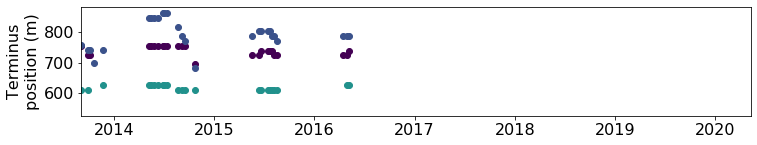

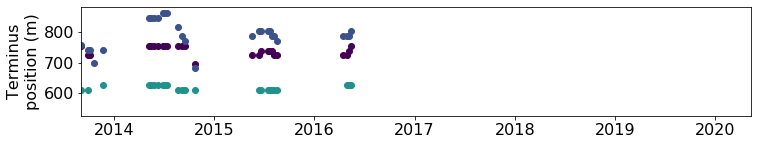

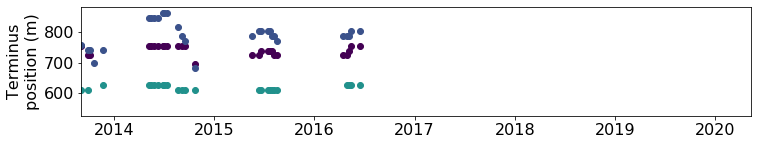

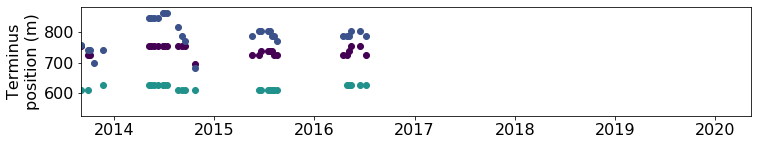

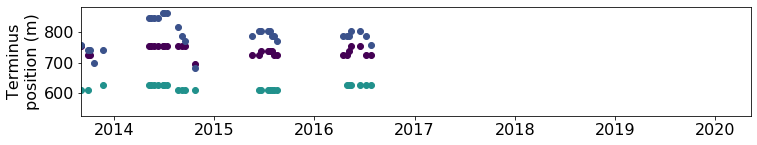

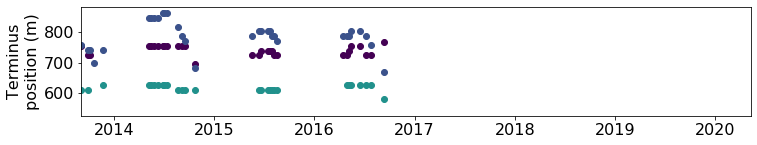

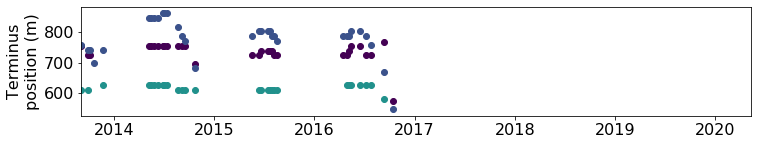

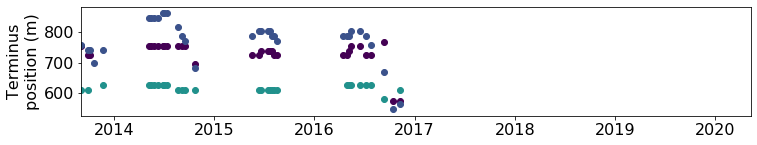

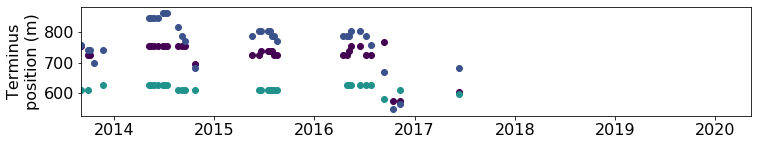

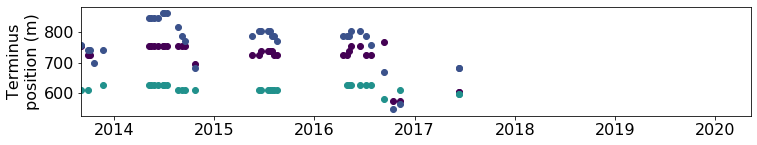

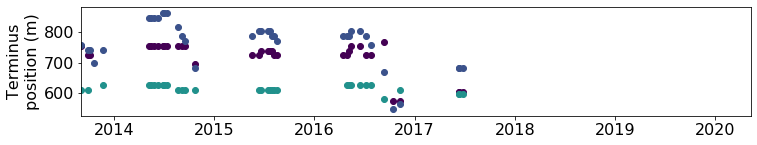

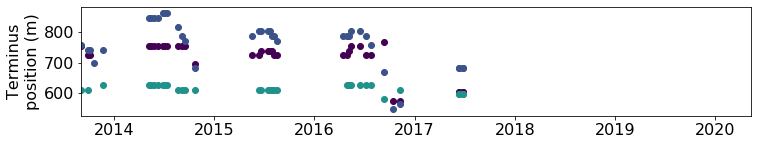

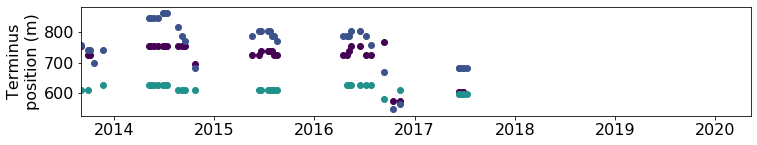

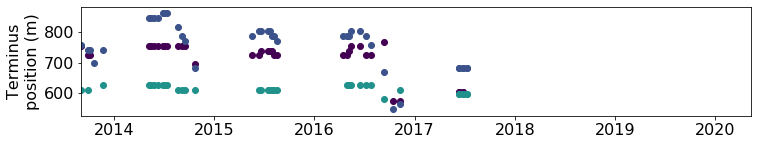

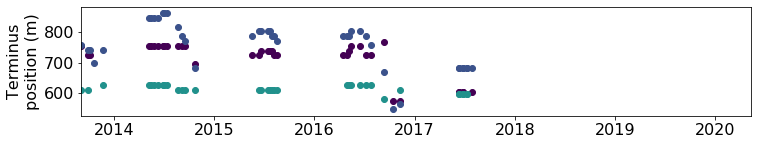

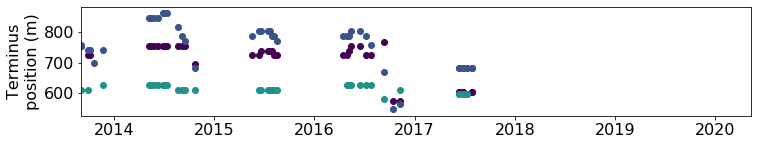

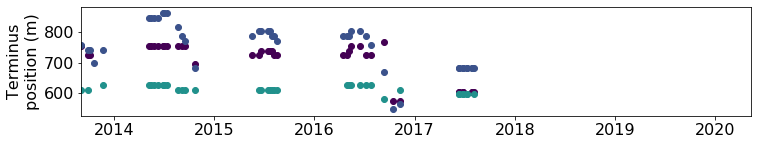

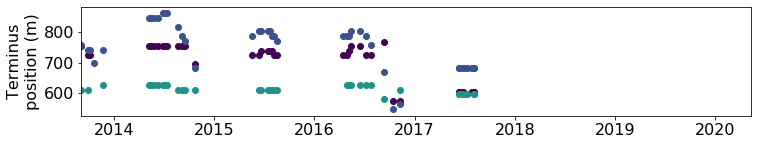

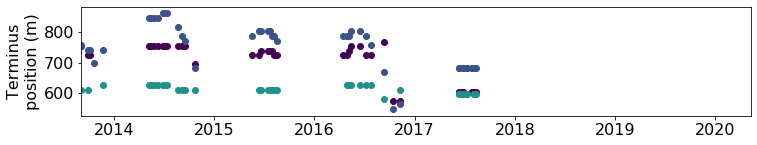

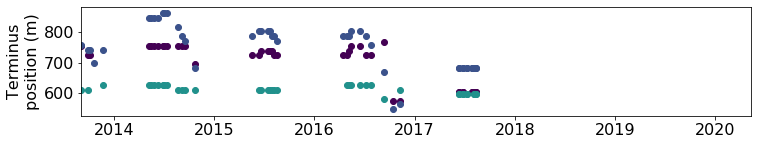

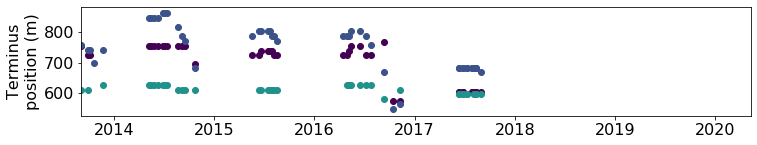

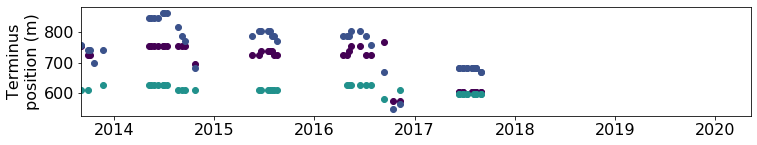

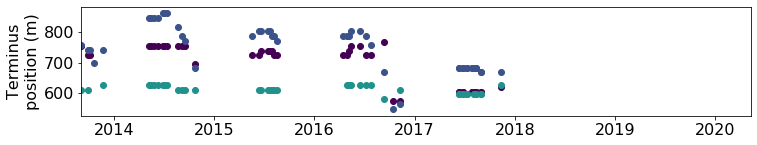

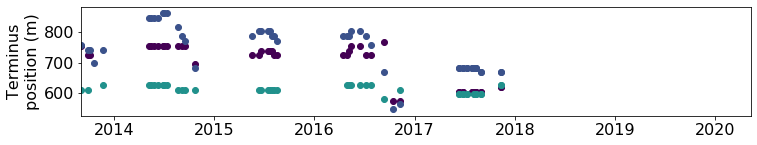

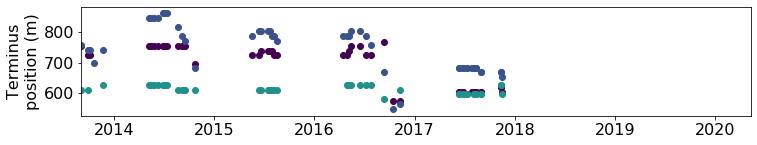

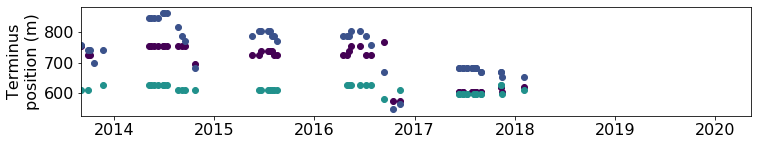

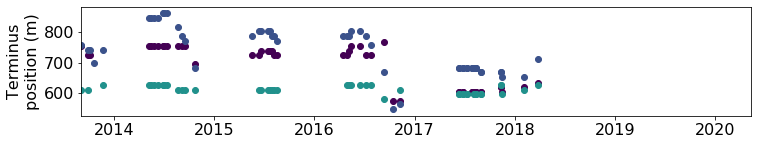

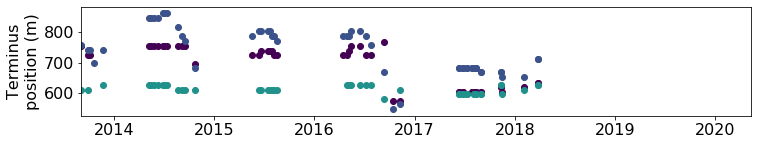

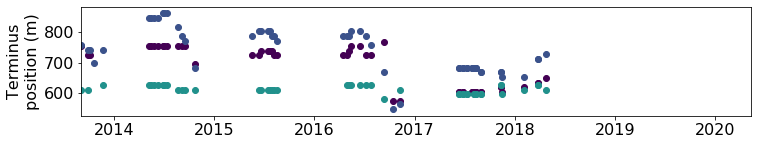

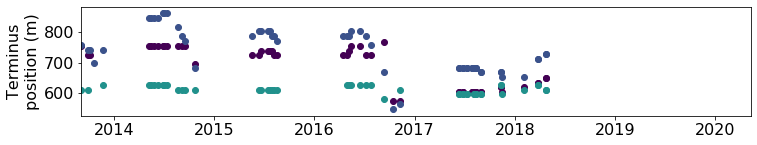

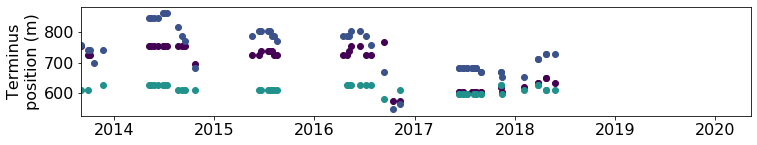

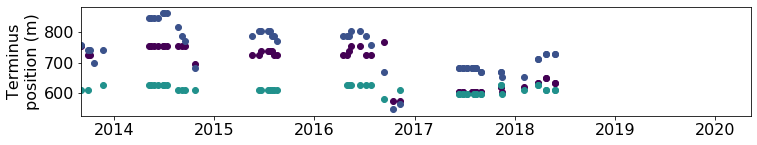

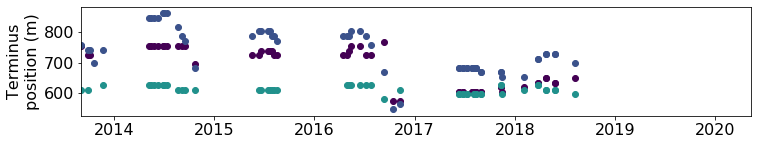

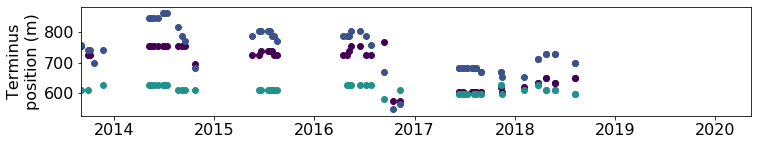

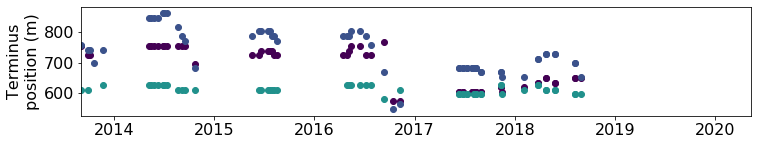

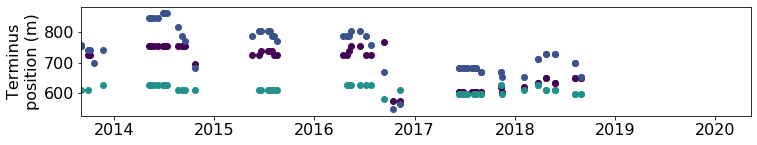

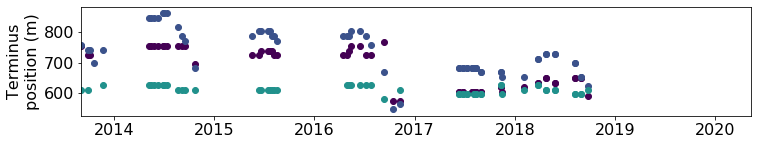

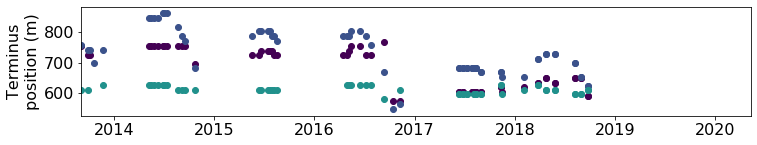

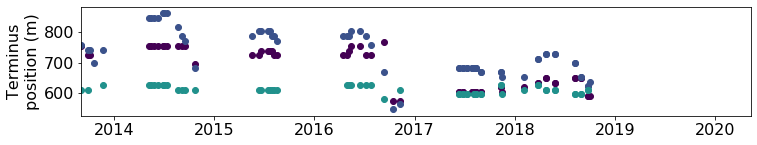

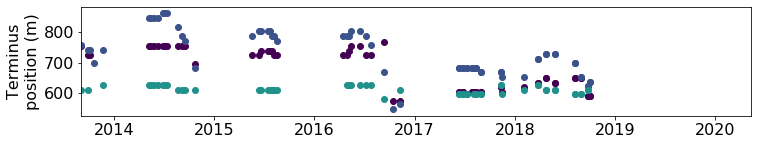

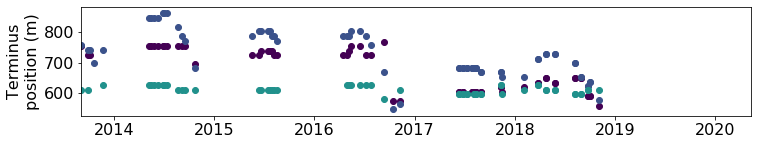

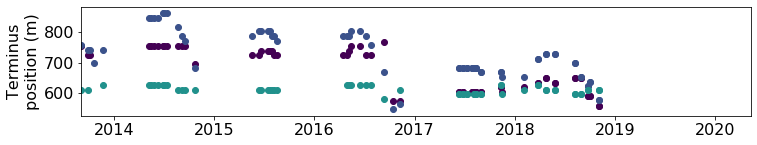

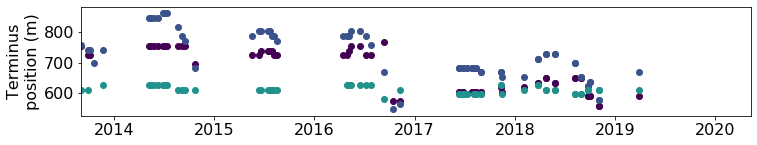

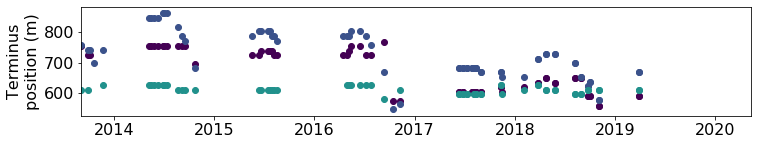

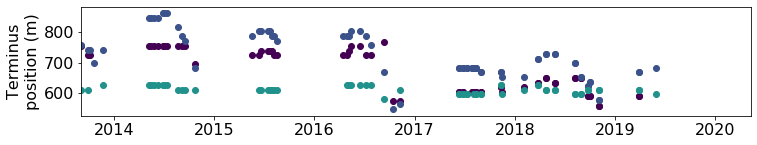

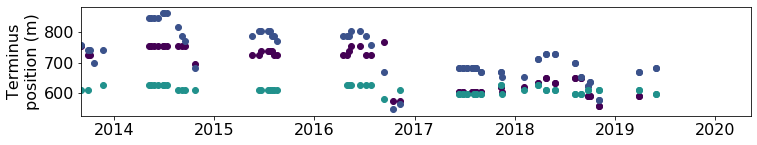

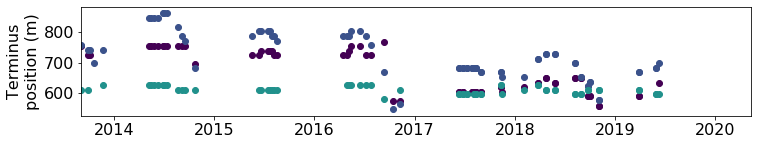

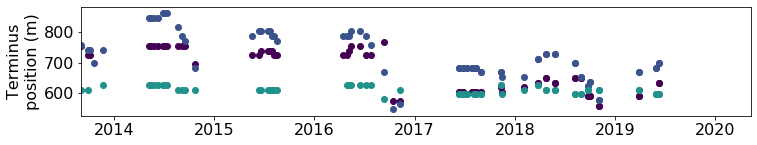

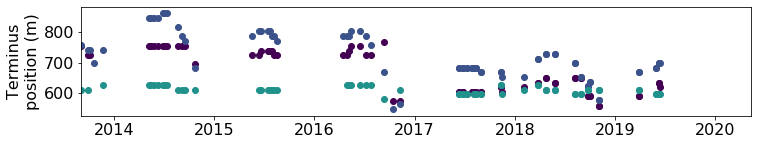

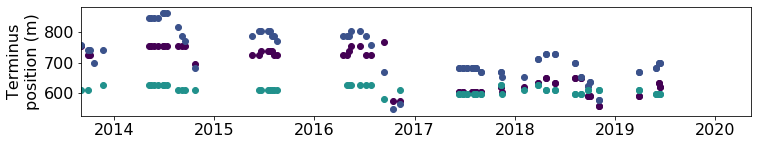

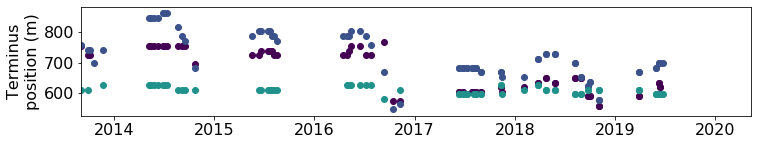

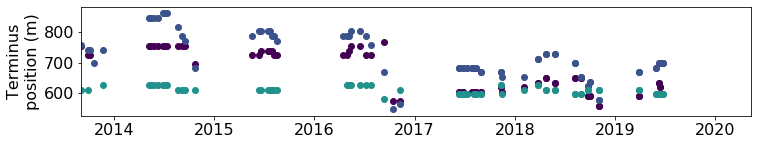

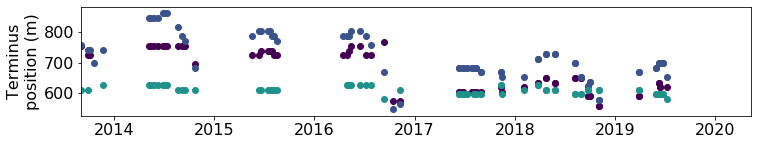

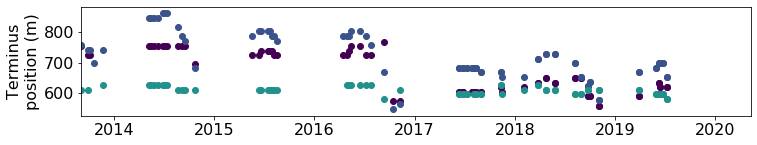

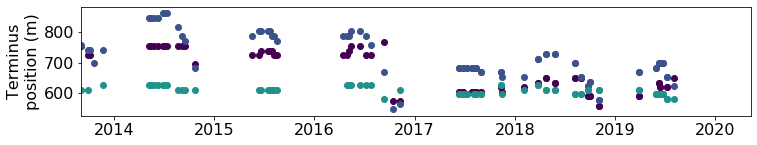

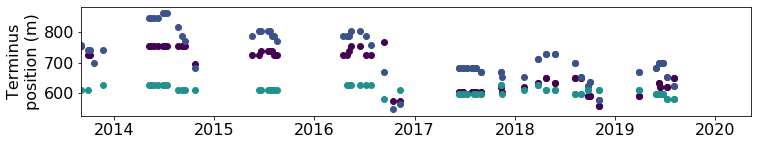

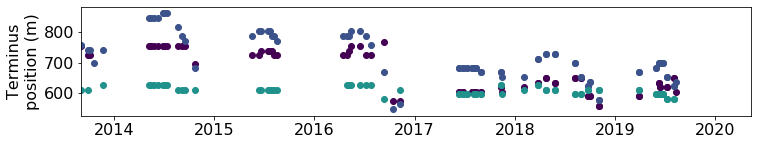

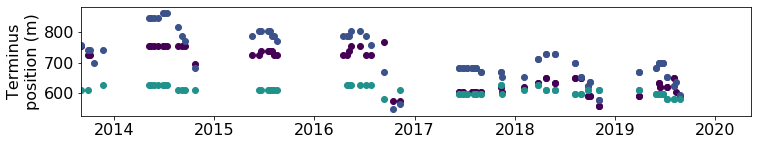

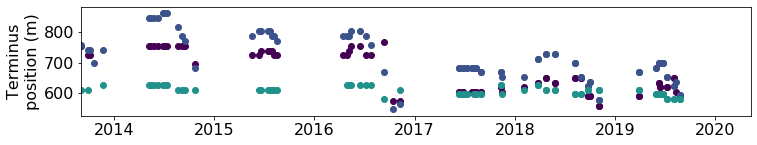

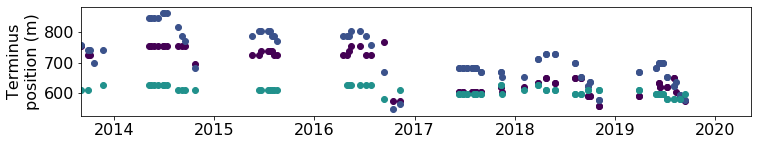

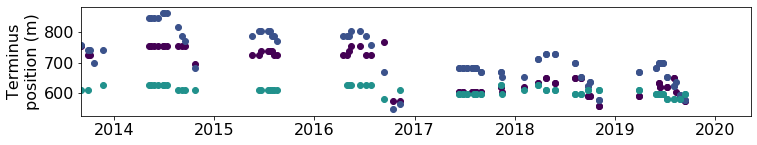

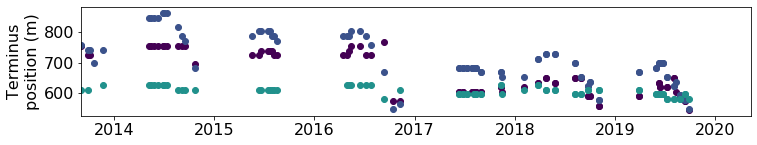

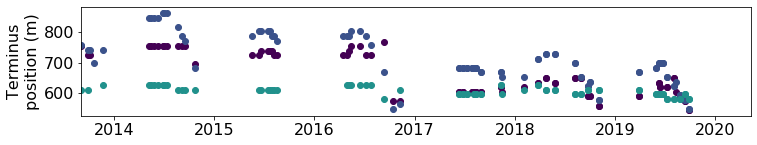

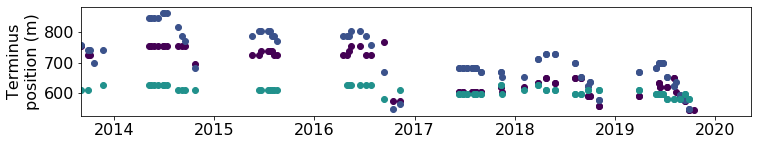

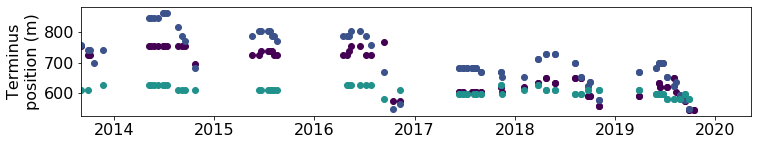

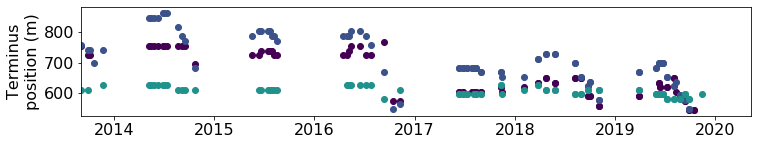

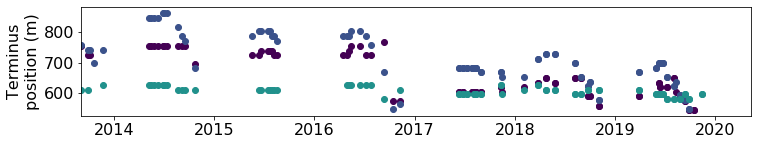

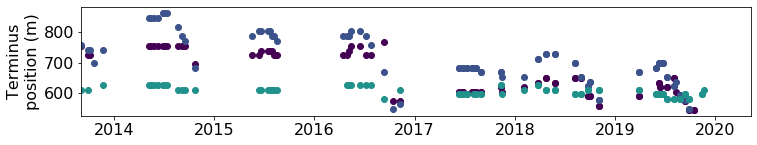

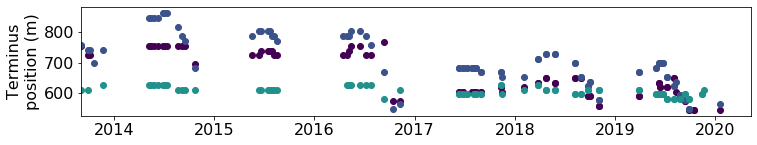

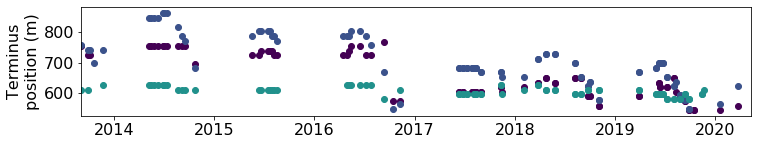

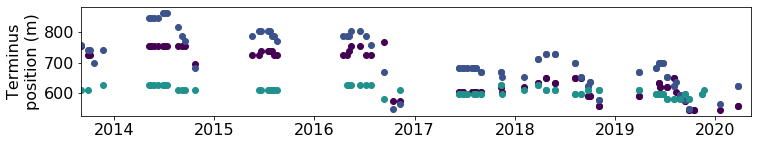

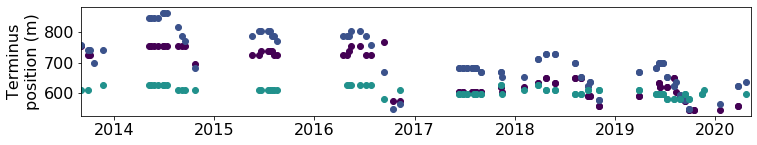

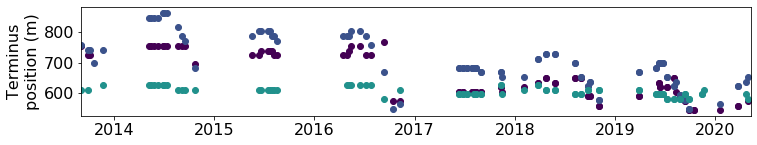

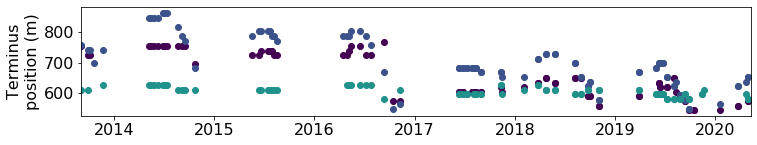

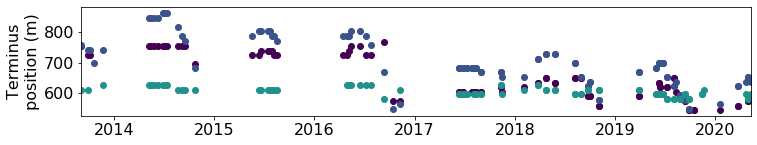

In [331]:
intersections50 = {}; is25 = {}; is75 = {};

colors = pl.cm.viridis(np.linspace(0,0.5,3)) # generate 3 centerline 
#grab y limits from tpos
ymax = np.nanmax([list(final_images_df.tpos50), list(final_images_df.tpos25), list(final_images_df.tpos75)]) + 20
ymin = np.nanmin([list(final_images_df.tpos50), list(final_images_df.tpos25), list(final_images_df.tpos75)]) - 20
datemin = list(final_images_df.datetimes)[0]
datemax = list(final_images_df.datetimes)[-1]
ymin=525
# ymax=650

dates = []; tpos50s = []; tpos25s = []; tpos75s = []
counter = 1
for index, row in final_images_df.iterrows():
    date = row['datetimes']
    trimdat = row['Trimmed_dat_filename']
    dat = row['Dat_filename']
    scene = row['Scene']
    BOI = row['BoxID']
    # Grab intersections:
    intersections50.update({row['Dat_filename']: row['X50']})
    is25.update({row['Dat_filename']: row['X25']}); is75.update({row['Dat_filename']: row['X75']})
    # Grab tpos:
    tpos50 = row['tpos50']; tpos25 = row['tpos25']; tpos75 = row['tpos75']; 
    
#     ###########################################################
#     # PLOT IMAGES
#     image = mpimg.imread(imagepath+"R_"+scene+"_B8_Buffer"+BOI+'_PS.png')
    
#     #Read in terminus box raster as an np array
#     tbox = mpimg.imread(basepath+"Box"+BOI+"/rotated_c1/R_Box"+BOI+"_raster_cut.png")
    
#     #set path to that image's datfiles:
#     datpath = imagepath+"R_"+scene+"_B8_Buffer"+BOI+"_PS.pgm_max_gaussian/"+metric
#     term_dat = np.loadtxt(datpath+dat)
    
#     datxs = {}; datys = {}
    
#     xs = []; ys = []
#     #grab x and y coordinates for the terminus line
#     for j in term_dat:
#         x, y = (j[0], j[1]); xs.append(x); ys.append(y)
        
#     #update into dat xs and ys dictionaries:
#     datxs.update({dat: xs}); datys.update({dat: ys})
    
#     #PLOT THE LANDSAT IMAGE and TERMINUS BOX
# #     fig, axs = plt.subplots(1, 2, figsize=(20,10))
#     plt.figure(figsize=(20,10)); plt.axis("off")
#     imgplt_trim = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     boxplt = plt.imshow(tbox, alpha=0.1)
    
#     #PLOT CENTERLINES
#     colors = pl.cm.viridis(np.linspace(0,0.5,3)) # generate 3 centerline 
#     #grab x values from centerline_df
#     xmin50 = float(centerline_df.loc[BOI]['lmid50_x']); xmin25 = float(centerline_df.loc[BOI]['lmid25_x'])
#     xmax50 = float(centerline_df.loc[BOI]['rmid50_x']); xmax25 = float(centerline_df.loc[BOI]['rmid25_x'])
#     xmin75 = float(centerline_df.loc[BOI]['lmid75_x'])
#     xmax75 = float(centerline_df.loc[BOI]['rmid75_x'])
#     cx50 = np.linspace(xmin50, xmax50, int(xmax50-xmin50)*2); cx75 = np.linspace(xmin75, xmax75, int(xmax75-xmin75)*2)
#     cx25 = np.linspace(xmin25, xmax25, int(xmax50-xmin50)*2)
#     #generate y-values using the slope and intercept
#     cy50 = float(centerline_df.loc[BOI]['m50'])*cx50 + float(centerline_df.loc[BOI]['b50'])  
#     cy25 = float(centerline_df.loc[BOI]['m25'])*cx25 + float(centerline_df.loc[BOI]['b25']) 
#     cy75 = float(centerline_df.loc[BOI]['m75'])*cx75 + float(centerline_df.loc[BOI]['b75']) 
#     plt.plot(cx50, cy50, '--w', cx25, cy25, '--w', cx75, cy75, '--w' ,linewidth=1.5, alpha=0.5)

#     #PLOT DATE in the top left corner
#     plt.text(int(0.02*image.shape[0]), int(0.035*image.shape[1]), str(date)[:10], fontsize=16, color='w')
        
#     #PLOT TOP PICK
#     plt.plot(datxs[dat], datys[dat], color='r')
    
#     #PLOT intersection points
#     ix50, iy50 = intersections50.get(dat); ix25, iy25 = is25.get(dat); ix75, iy75 = is75.get(dat)
#     ms=8
#     plt.plot(ix50, iy50, color = colors[1], marker='o', markersize=ms)
#     plt.plot(ix25, iy25, color = colors[0], marker='o', markersize=ms)
#     plt.plot(ix75, iy75, color = colors[2], marker='o', markersize=ms)
        
#     #PLOT midpoints for figure
#     plt.plot(xmin50, float(centerline_df.loc[BOI]['lmid50_y']), marker='s', color=colors[1], markersize=8)
#     plt.plot(xmin25, float(centerline_df.loc[BOI]['lmid25_y']), marker='s', color=colors[0], markersize=8)
#     plt.plot(xmin75, float(centerline_df.loc[BOI]['lmid75_y']), marker='s', color=colors[2], markersize=8)
    
#     #save fig
#     plt.savefig(basepath+"Box"+BOI+"/Results_c1/Tpos_timeseries_images_anim"+str(counter)+".png", dpi=200, bbox_inches='tight')
    
#     ################################################################
    #plot timeseries
    dates.append(date); tpos50s.append(tpos50); tpos25s.append(tpos25); tpos75s.append(tpos75)
    fs=16
    plt.figure(figsize=(12,2))
    plt.ylim(ymin, ymax)
    plt.xlim(datetime.date(datemin), datetime.date(datemax))
    plt.xticks(fontsize=fs); plt.yticks(fontsize=fs)
    plt.ylabel('Terminus\nposition (m)', fontsize=fs)
    plt.plot_date(list(dates), list(tpos25s), color=colors[0])
    plt.plot_date(list(dates), list(tpos50s), color=colors[1])
    plt.plot_date(list(dates), list(tpos75s), color=colors[2])
    
    #save fig
    plt.savefig(basepath+"Box"+BOI+"/Results_c1/Tpos_timeseries_anim"+str(counter)+".png", dpi=200, bbox_inches='tight')
    
    ################################################################
    plt.show()
    counter = counter+1
#     clear_output()

In [280]:
# # for index, row in dated_images_df.iterrows():
# uniquescenes = set(list(final_images_df['Scene'])); len(uniquescenes)

# for scene in uniquescenes:    
#     #separate the df by scene:
#     scene_df = final_images_df[final_images_df['Scene'] == scene].copy()

#     #sort by descending order so the worse orders are plotted first and the better orders are plotted on top
#     scene_df = scene_df.sort_values(by='Order', ascending=False);
    
#     #grab the date for the scene (just use the first since all should be the same)
#     date = list(scene_df.datetimes)[0]
    
#     #loop through the rows for each scene and append info to these lists
#     trimdatfiles = []; datfiles = []; orders = []; intersections50 = {}; is25 = {}; is75 = {};
    
#     for index, row in scene_df.iterrows():
#         #grab the terminus_trim files and append to list
#         trimdatfiles.append(row['Trimmed_dat_filename']); datfiles.append(row['Dat_filename'])
#         #grab the order to be plotted later:
#         orders.append(row['Order'])
#         #grab the intersections to be plotted later:
#         intersections50.update({row['Dat_filename']: row['X50']})
#         is25.update({row['Dat_filename']: row['X25']}); is75.update({row['Dat_filename']: row['X75']})

#     #Read in the image.png as np array
#     image = mpimg.imread(imagepath+"R_"+scene+"_B8_Buffer"+BOI+'_PS.png')
    
#     #Read in terminus box raster as an np array
# #     tbox = mpimg.imread(csvpaths+"Box"+BOI+"/rotated_images/final/crop_Box"+BOI+"_raster_cut.pgm")
#     tbox = mpimg.imread(basepath+"Box"+BOI+"/rotated_c1/R_Box"+BOI+"_raster_cut.png")
    
#     #set path to that image's datfiles:
#     datpath = imagepath+"R_"+scene+"_B8_Buffer"+BOI+"_PS.pgm_max_gaussian/"+metric
    
#     #grab dat xs and ys
#     datxs = {}; datys = {}
    
#     for i in range(0, len(trimdatfiles)):
# #         trimdat = trimdatfiles[i]
#         dat = datfiles[i]
# #         print(trimdat)
#         #Read in dat file as np array and grab x and y values
# #         term_trim_dat = np.loadtxt(datpath+trimdat)
#         term_dat = np.loadtxt(datpath+dat)
# #         print(term_trim_dat.shape)
        
#         xs = []; ys = []
#         #grab x and y coordinates for the terminus line
#         for j in term_dat:
#             x, y = (j[0], j[1]); xs.append(x); ys.append(y)
        
#         #update into dat xs and ys dictionaries:
#         datxs.update({dat: xs}); datys.update({dat: ys})
        
#     #grab the top pick
#     toppick = datfiles[0]
    
#     #PLOT THE LANDSAT IMAGE and TERMINUS BOX
# #     fig, axs = plt.subplots(1, 2, figsize=(20,10))
#     plt.figure(figsize=(20,10)); plt.axis("off")
#     imgplt_trim = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     boxplt = plt.imshow(tbox, alpha=0.1)
    
#     #PLOT CENTERLINES
#     colors = pl.cm.viridis(np.linspace(0,0.5,3)) # generate 3 centerline 
#     #grab x values from centerline_df
#     xmin50 = float(centerline_df.loc[BOI]['lmid50_x']); xmin25 = float(centerline_df.loc[BOI]['lmid25_x'])
#     xmax50 = float(centerline_df.loc[BOI]['rmid50_x']); xmax25 = float(centerline_df.loc[BOI]['rmid25_x'])
#     xmin75 = float(centerline_df.loc[BOI]['lmid75_x'])
#     xmax75 = float(centerline_df.loc[BOI]['rmid75_x'])
#     cx50 = np.linspace(xmin50, xmax50, int(xmax50-xmin50)*2); cx75 = np.linspace(xmin75, xmax75, int(xmax75-xmin75)*2)
#     cx25 = np.linspace(xmin25, xmax25, int(xmax50-xmin50)*2)
#     #generate y-values using the slope and intercept
#     cy50 = float(centerline_df.loc[BOI]['m50'])*cx50 + float(centerline_df.loc[BOI]['b50'])  
#     cy25 = float(centerline_df.loc[BOI]['m25'])*cx25 + float(centerline_df.loc[BOI]['b25']) 
#     cy75 = float(centerline_df.loc[BOI]['m75'])*cx75 + float(centerline_df.loc[BOI]['b75']) 
#     plt.plot(cx50, cy50, '--w', cx25, cy25, '--w', cx75, cy75, '--w' ,linewidth=1.5, alpha=0.5)

#     #PLOT DATE in the top left corner
#     plt.text(int(0.02*image.shape[0]), int(0.035*image.shape[1]), str(date), fontsize=16, color='w')
    
    
# #     #PLOT ALL TOP PICKS in different shades of purple
# #     #create five shades for each order
# #     colors = pl.cm.plasma_r(np.linspace(0,1,5))
# #     col_count = 0
# #     #plot number of lines
# #     plt.text(int(0.02*image.shape[0]), int(0.07*image.shape[0]), "Lines: "+str(len(datfiles)), fontsize=16, color='w')
# #     #plot each termline
# #     for line in datfiles:
# #         #grab the x and y values for that termline
# #         x, y = datxs[line], datys[line]
# #         #plot with color scheme
# #         plt.plot(x, y, color=colors[col_count], linewidth=2)
# #         col_count = col_count+1
        
#     #PLOT TOP PICK
#     plt.plot(datxs[toppick], datys[toppick], color='r')
    
#     #PLOT intersection points
#     ix50, iy50 = intersections50.get(toppick); ix25, iy25 = is25.get(toppick); ix75, iy75 = is75.get(toppick)
#     plt.plot(ix50, iy50, 'kx', ix25, iy25, 'kx', ix75, iy75, 'kx', markersize=10)
        
#     #PLOT midpoints for figure
#     plt.plot(xmin50, float(centerline_df.loc[BOI]['lmid50_y']), marker='s', color=colors[1], markersize=8)
#     plt.plot(xmin25, float(centerline_df.loc[BOI]['lmid25_y']), marker='s', color=colors[0], markersize=8)
#     plt.plot(xmin75, float(centerline_df.loc[BOI]['lmid75_y']), marker='s', color=colors[2], markersize=8)
    
# #     axs[1].plot()
#     #SAVE AND DELAY
#     plt.savefig(basepath+"Box"+BOI+"/Results_c1/"+str(date)+"_trim_"+scene+".png", dpi=200, bbox_inches='tight')
#     plt.show()
# #     sleep(1)
# #     clear_output()
# # print("Done.")

## 4) Plot terminus position and change rate timeseries

### Filtering using max flow speeds

Grab max flow threshold from glacier velocities:

In [22]:
# #Grab max flow threshold from glacier velocities in flowspeed_df
# max_flow = float(flowspeed_df['Max_speed'][BOI])
# if max_flow < 1.0:
#     flow_thresh = 5.0
# else:
#     flow_thresh = 5.0*max_flow
# print(flow_thresh)

Filter for sudden dips in the time series:

In [23]:
# #REMOVE DIPS 
# N1 = 3
# nodips = []
# for df in dfs_new:
#     nodips.append(remove_dips(df, flow_thresh, N1))

Filter for sudden jumps in the time series

In [24]:
# #REMOVE JUMPS
# N2 = 2
# nojumps = []
# for df in nodips:
#     nojumps.append(remove_jumps(df, flow_thresh, N2))

In [25]:
# fig, ax1 = plt.subplots(figsize=(12,6))
# # ax1.plot(final_images_df['datetimes'], final_images_df['term_position'], 'mo', markersize = 5)
# colors = pl.cm.plasma(np.linspace(0,1,5))

# df1 = final_images_50[final_images_50['Order'] == '1'].copy(); df2 = final_images_50[final_images_50['Order'] == '2'].copy()
# df3 = final_images_50[final_images_50['Order'] == '3'].copy(); df4 = final_images_50[final_images_50['Order'] == '4'].copy()
# df5 = final_images_50[final_images_50['Order'] == '5'].copy()

# ax1.plot(df5['datetimes'], df5['tpos'], color = colors[4], marker='o', markersize=5, lw=0)
# ax1.plot(df4['datetimes'], df4['tpos'], color = colors[3], marker='o', markersize=5, lw=0)
# ax1.plot(df3['datetimes'], df3['tpos'], color = colors[2], marker='o', markersize=5, lw=0)
# ax1.plot(df2['datetimes'], df2['tpos'], color = colors[1], marker='o', markersize=5, lw=0)
# ax1.plot(df1['datetimes'], df1['tpos'], color = colors[0], marker='o', markersize=5, lw=0)

# ax1.set_ylabel('Terminus position (m)', color='k', fontsize=14)
# ax1.set_xlabel('Date', fontsize=14)
# ax1.tick_params(axis='both', which='major', labelsize=14)

# # plt.savefig(csvpaths+"/Figures/filtering/Timeseries_final_top1_"+BOI+"_"+analysis_date+".png", dpi=500)
# plt.show()

In [26]:
# min_time = list(final_images_df['datetimes'])[0]
# max_time = list(final_images_df['datetimes'])[-1]

In [27]:
# fig, ax1 = plt.subplots(figsize=(12,6))
# #TERMINUS POSITION
# ax1.plot(nojumps75['datetimes'], nojumps75['tpos'], 'mo', markersize='4')
# # ax1.plot(dips_df['datetimes'], dips_df['Term_position'], 'ko', markersize='4')
# plt.show()

Grab only those terminus positions corresponding to the highest order terminus pick.

In [28]:
# orders25

In [29]:
# #Grab highest orders:
# highestorder_dfs = []
# for df in nojumps:
#     #grab unique dates
#     unique_dates = set(list(df['datetimes']))
#     print(len(unique_dates))
#     #grab highest orders:
#     order_list = []
#     for date in unique_dates:
#         date_df = df[df['datetimes'] == date].copy()
#         highestorder = np.min(np.array(date_df['Order']))
#         order_list.append(highestorder)
#     highestorder_df = pd.DataFrame(list(zip(unique_dates, order_list)), columns=['datetimes', 'Order']).sort_values(by='datetimes', ascending=True)
#     highestorder_dfs.append(highestorder_df)

Inner merge with final_images_df to only keep those of the highest order

In [30]:
# onepick_dfs = []
# for i in range(0, len(highestorder_dfs)):
#     onepick_df = nojumps[i].merge(highestorder_dfs[i], how='inner', on=['datetimes', 'Order'])
#     onepick_dfs.append(onepick_df)
#     print(onepick_df.shape[0])
    
# onepick_df = nojumps.merge(highestorder_df, how='inner', on=['datetimes', 'Order']); print(onepick_df.shape[0])
# onepick_df25 = nojumps25.merge(highestorder_df25, how='inner', on=['datetimes', 'Order']); print(onepick_df25.shape[0])
# onepick_df75 = nojumps75.merge(highestorder_df75, how='inner', on=['datetimes', 'Order']); print(onepick_df75.shape[0])
# onepick_df.head()

In [31]:
# onepick_df = final_images_df.merge(highestorder_df, how='inner', on=['datetimes', 'Order'])
# print(onepick_df.shape[0])
# onepick_df

In [32]:
# posmax = np.max(onepick_df['tpos']); print(posmax)
# posmax25 = np.max(onepick_df25['tpos']); print(posmax25)
# posmax75 = np.max(onepick_df75['tpos']); print(posmax75)

## Plotting:

In [33]:
# fig, ax1 = plt.subplots(figsize=(12,4))
# markers = ['mo', 'ro', 'bo']

# #PLOT TERMINUS POSITIONS ALONG 3 CENTERLINES
# for j in range(0, len(onepick_dfs)):
#     df = onepick_dfs[j];    print(len(df))
#     ax1.plot(df['datetimes'], df['tpos'], markers[j], markersize=5, alpha=0.8)

# # final_images_df.plot(x='datetimes', y='term_position', 
# #             c=final_images_df['Order'], markersize='4', colormap='RdPu_r', legend=None)
# ax1.set_ylabel('Terminus position (m)', color='k', fontsize=12)

# #GENERAL PLOT PARAMETERS
# ax1.set_title("Box"+BOI, fontsize=16)
# ax1.set_xlabel('Date', fontsize=12)
# ax1.tick_params(axis='both', which='major', labelsize=12)

# #SAVE FIGURE
# plt.savefig(csvpaths+"/Figures/Termposition_LS8_m_Box"+BOI+"_"+analysis_date+".png", dpi=200)
# plt.legend(['1/2', '1/4', '3/4'])
# plt.show()

In [34]:
# flowlines = ['flowline50', 'flowline25', 'flowline75']
# for k in range(0, len(onepick_dfs)):
#     df = onepick_dfs[k];
#     df.to_csv(path_or_buf = csvpaths+'Tpos_Box'+BOI+'_'+flowlines[k]+'_filtered.csv', sep=',')